# 1. Introduction

In [152]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and check Data

## 2.1 Load Data

In [153]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [154]:
def detect_outliers(df, n, features):
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

In [155]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [156]:
train_len = len(train)
print(train_len)

891


In [157]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 2.3 joining train and test set

In [158]:
train_len = len(train)
print(train_len)
dataset = pd.concat(objs = [train, test], axis=0).reset_index(drop=True)

881


## 2.4 check for null and missing values

In [159]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [160]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [161]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [162]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [163]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3.1 Numerical values

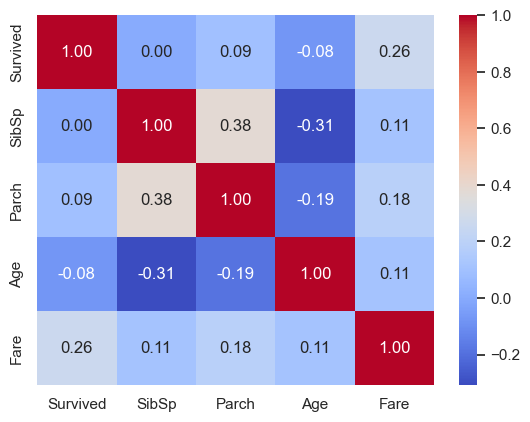

In [164]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

### SibSP

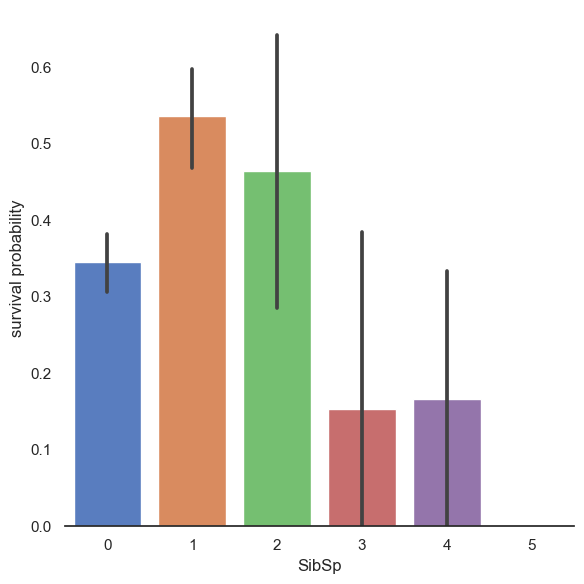

In [165]:
g = sns.catplot(x='SibSp', y = 'Survived', data = train, kind="bar", height = 6, palette= "muted")
g.despine(left=True)
g.despine(left=True)
g = g.set_ylabels("survival probability")

### Parch

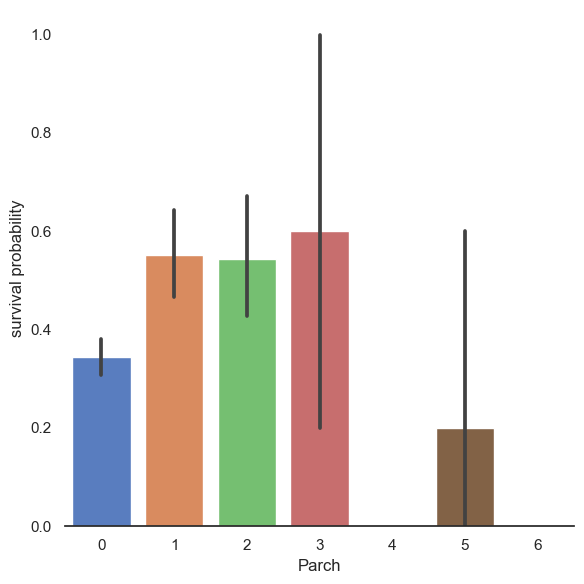

In [166]:
g = sns.catplot(x = 'Parch', y = 'Survived', data=train, kind = 'bar', height = 6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

### Age

/Users/leewonseok/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/leewonseok/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


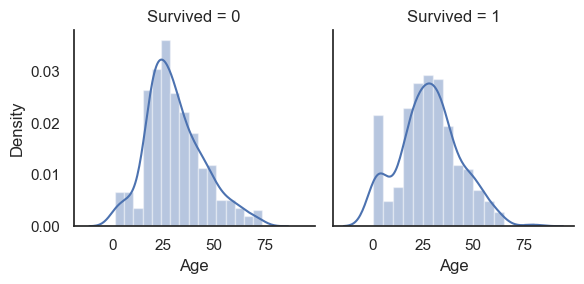

In [167]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, "Age")

/var/folders/jg/6pk3l_6d1dg84wjxlhwgdtt80000gn/T/ipykernel_2513/1148592536.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
/var/folders/jg/6pk3l_6d1dg84wjxlhwgdtt80000gn/T/ipykernel_2513/1148592536.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color = 'Blue', shade = True)


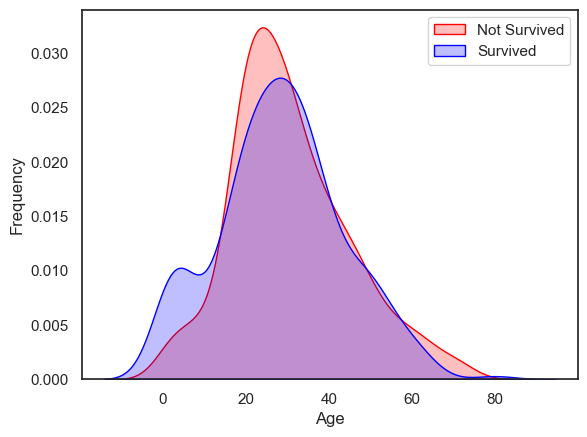

In [168]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color = 'Blue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

### Fare

In [169]:
dataset['Fare'].isnull().sum()

1

In [170]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

/var/folders/jg/6pk3l_6d1dg84wjxlhwgdtt80000gn/T/ipykernel_2513/3690995446.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f' % (dataset['Fare'].skew()))


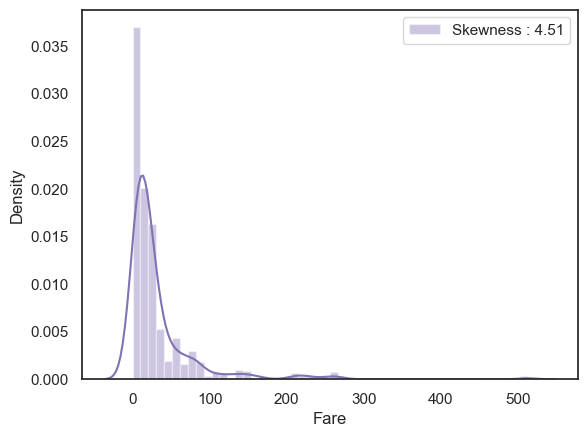

In [171]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f' % (dataset['Fare'].skew()))
g = g.legend(loc = 'best')

In [172]:
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

/var/folders/jg/6pk3l_6d1dg84wjxlhwgdtt80000gn/T/ipykernel_2513/3958525374.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color = 'b', label='Skewness : %.2f' % (dataset['Fare'].skew()))


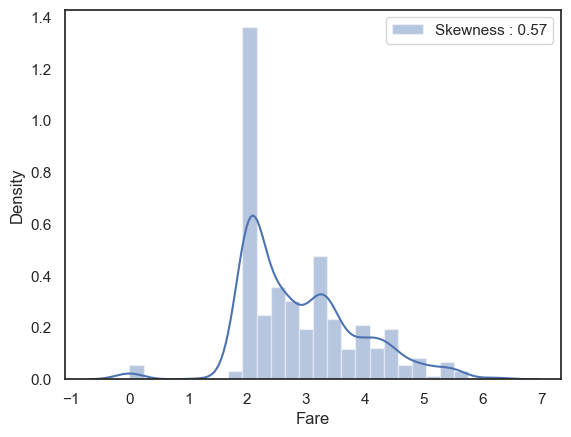

In [173]:
g = sns.distplot(dataset['Fare'], color = 'b', label='Skewness : %.2f' % (dataset['Fare'].skew()))
g = g.legend(loc='best')

## 3.2 Categorical values

### Sex

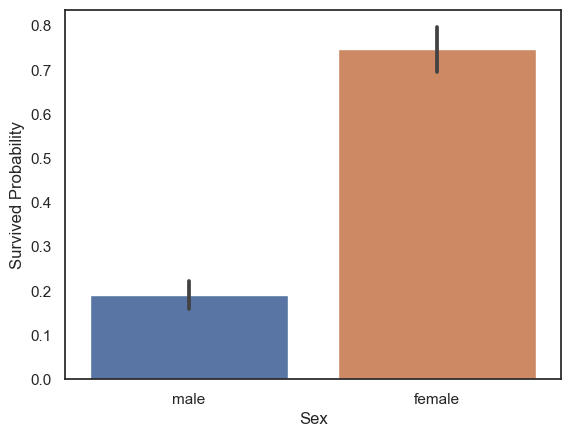

In [174]:
g = sns.barplot(x='Sex', y = 'Survived', data=train)
g = g.set_ylabel('Survived Probability')

In [175]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


### Pclass

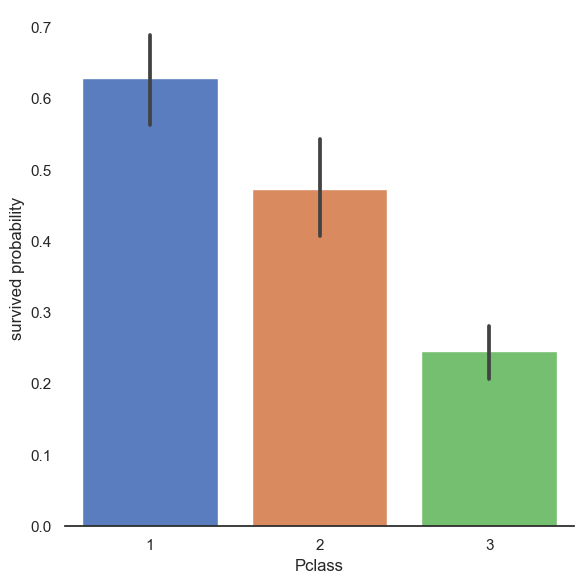

In [176]:
g = sns.catplot(x = 'Pclass', y = 'Survived', data=train, kind = 'bar', height=6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survived probability')

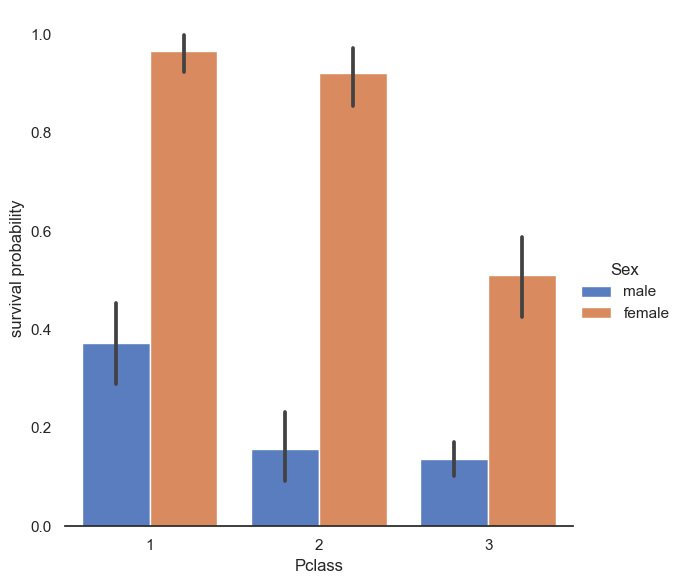

In [177]:
g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, height=6, kind='bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

### Embarked

In [178]:
dataset['Embarked'].isnull().sum()

2

In [179]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

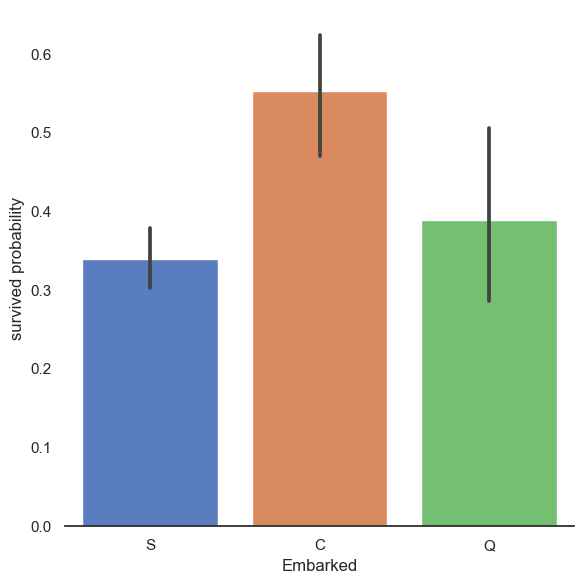

In [180]:
g = sns.catplot(x = 'Embarked', y = 'Survived', data=train, height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survived probability')

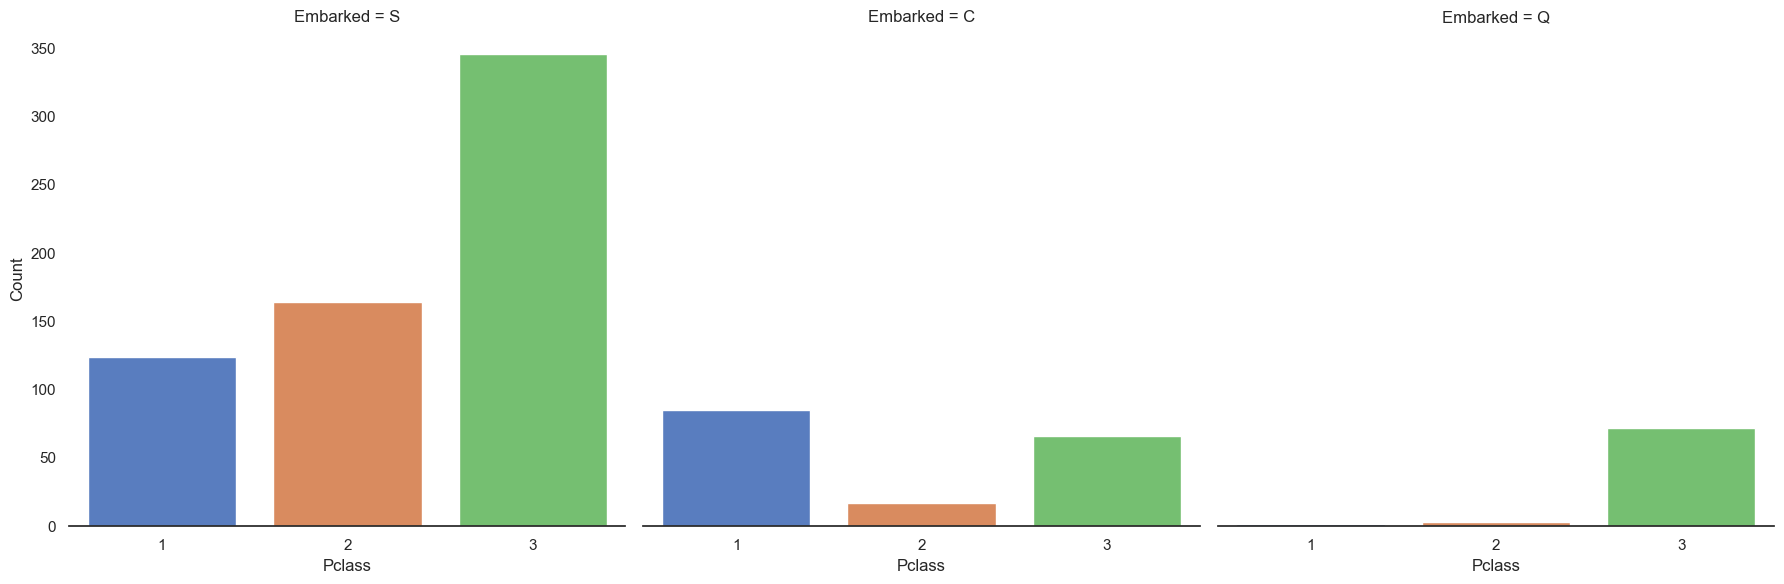

In [181]:
g = sns.catplot(x='Pclass', col = 'Embarked', data = train, height= 6, kind = 'count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

# 4. Filling missing Values

## 4.1 Age

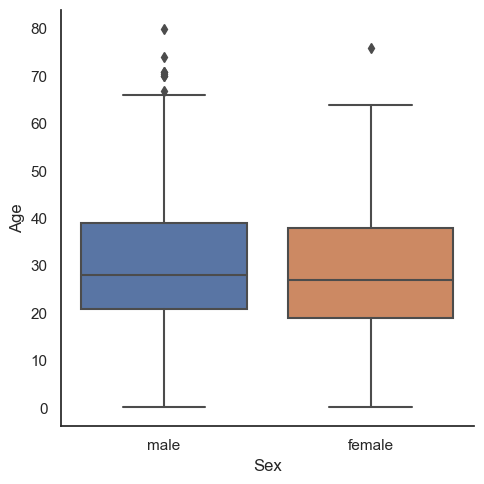

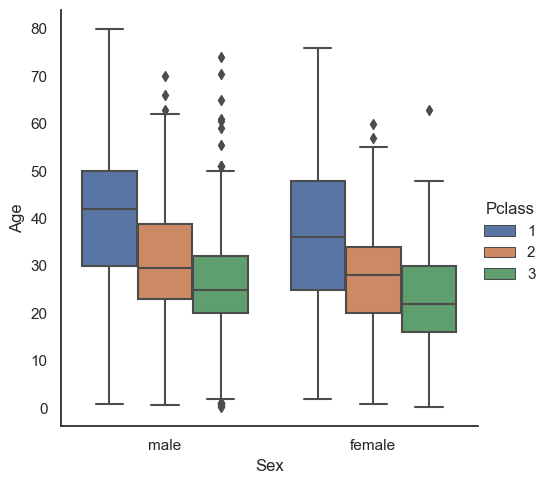

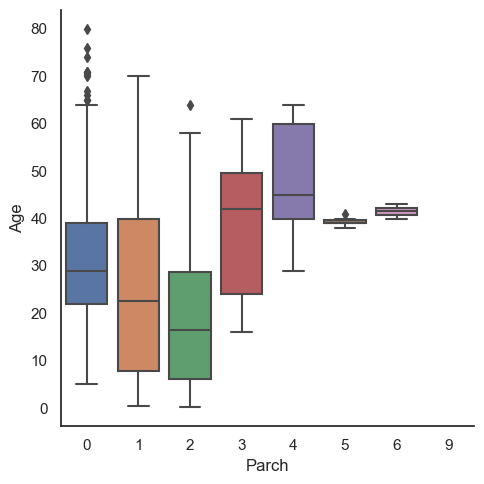

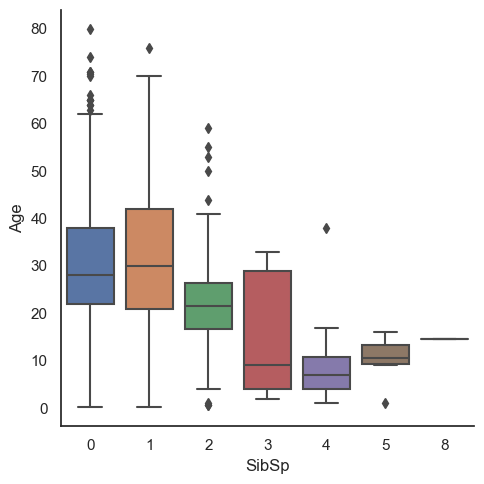

In [182]:
g = sns.catplot(y = 'Age', x ='Sex', data=dataset, kind='box')
g = sns.catplot(y = 'Age', x ='Sex', hue = 'Pclass', data=dataset, kind='box')
g = sns.catplot(y = 'Age', x ='Parch', data=dataset, kind='box')
g = sns.catplot(y = 'Age', x ='SibSp', data=dataset, kind='box')

In [183]:
dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1})

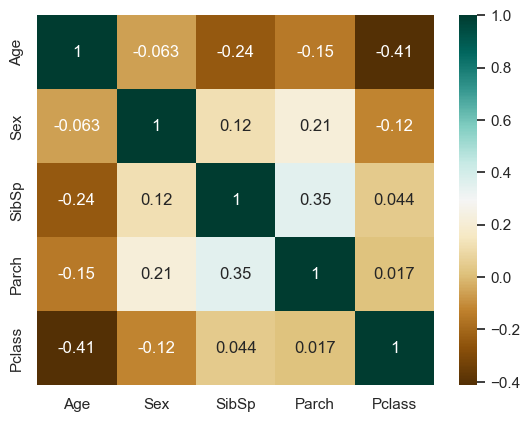

In [184]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

In [185]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/var/folders/jg/6pk3l_6d1dg84wjxlhwgdtt80000gn/T/ipykernel_2513/751177330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/var/folders/jg/6pk3l_6d1dg84wjxlhwgdtt80000gn/T/ipykernel_2513/751177330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_med


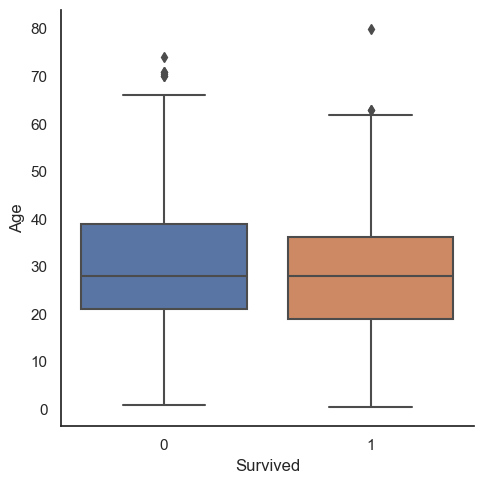

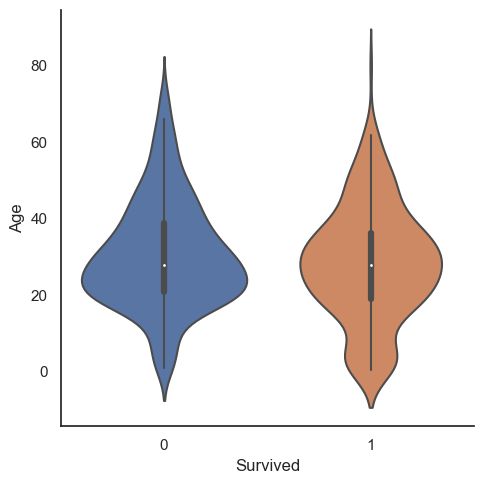

In [186]:
g = sns.catplot(x='Survived', y = 'Age', data = train, kind = 'box')
g = sns.catplot(x='Survived', y = 'Age', data = train, kind = 'violin')

# 5. Feature engineering

## 5.1 Name / Title

In [187]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [188]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [189]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

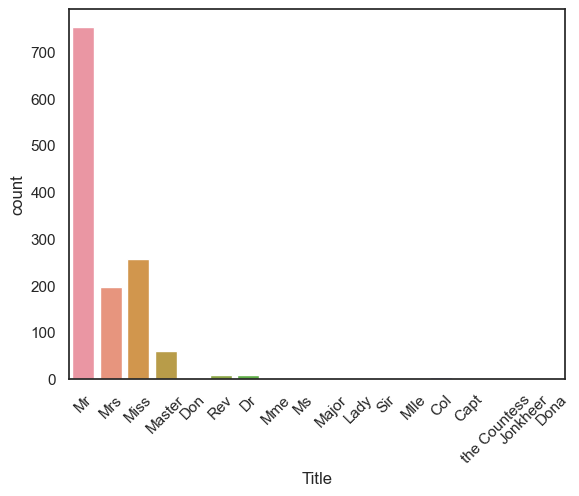

In [190]:
g = sns.countplot(x =  'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [191]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master': 0, 'Miss': 1, 'Ms': 2, 'Mme': 1, 'Mlle':1, 'Mrs': 1, 'Mr':2, 'Rare': 3})
dataset['Title'] = dataset['Title'].astype(int)

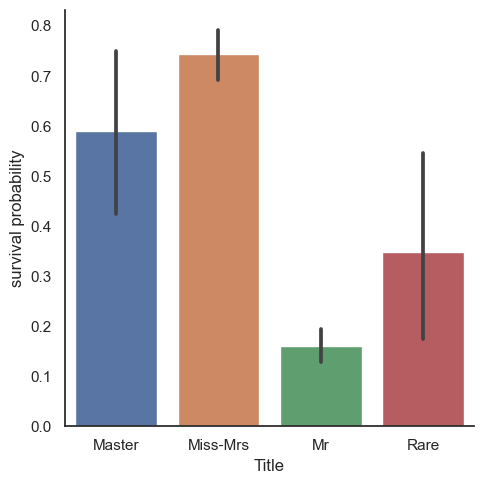

In [192]:
g = sns.catplot(x = 'Title', y = 'Survived', data=dataset, kind = 'bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [193]:
dataset.drop(labels = ['Name'], axis = 1,inplace = True)

## 5.2 Familiy size

In [194]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/Users/leewonseok/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/leewonseok/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


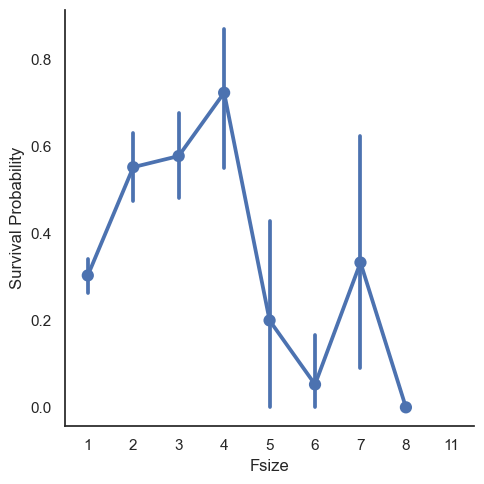

In [195]:
g = sns.catplot(x = 'Fsize', y = 'Survived', data=dataset, kind='point')
g = g.set_ylabels('Survival Probability')

In [196]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >=5 else 0)

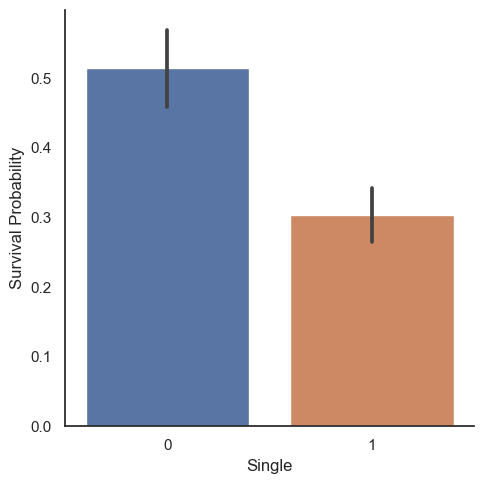

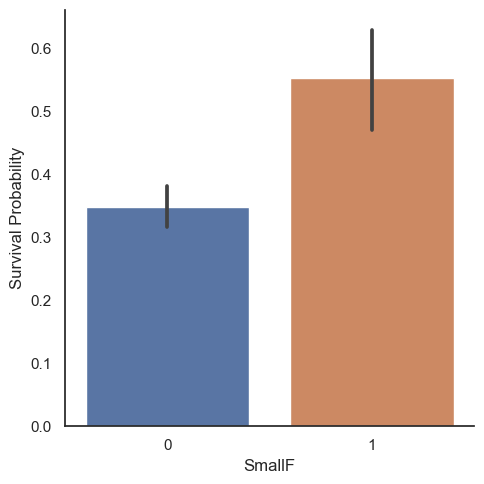

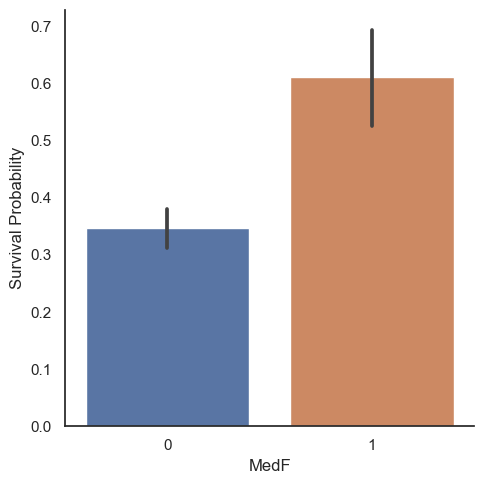

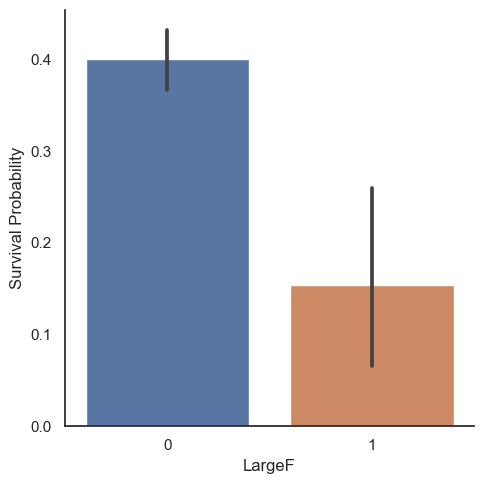

In [197]:
g = sns.catplot(x='Single', y = 'Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'SmallF', y = 'Survived', data = dataset, kind= 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'MedF', y = 'Survived', data = dataset, kind= 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'LargeF', y = 'Survived', data = dataset, kind= 'bar')
g = g.set_ylabels('Survival Probability')

In [198]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

## 5.3 Cabin

In [199]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [200]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [201]:
dataset['Cabin'].isnull().sum()

1007

In [202]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [203]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

/Users/leewonseok/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


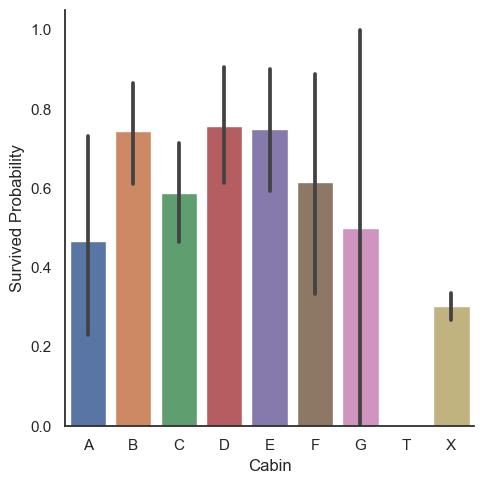

In [204]:
g = sns.catplot(y ='Survived', x = 'Cabin', data= dataset, kind = 'bar', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survived Probability')

In [205]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,X,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,X,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,X,...,0,0,0,0,0,1,0,0,0,1


In [206]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

In [207]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,0,0,0,0,0,0,0,0,1


## 5.4 Ticket

In [208]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [209]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","".strip().split(' ')[0]))
    else:
        Ticket.append("X")

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0          A/5 21171
1           PC 17599
2    STON/O2 3101282
3                  X
4                  X
Name: Ticket, dtype: object

In [210]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

In [211]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fsize,Single,...,T_W/C 14258,T_W/C 14260,T_W/C 14263,T_W/C 14266,T_W/C 6607,T_W/C 6608,T_W/C 6609,T_WE/P 5735,T_WEP 5734,T_X
0,1,0.0,3,0,22.0,1,0,1.981001,2,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,1,38.0,1,0,4.266662,2,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,2.070022,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1.0,1,1,35.0,1,0,3.972177,2,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,2.085672,1,1,...,0,0,0,0,0,0,0,0,0,1


In [212]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix ='Pc')

In [213]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [214]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_W/C 14266,T_W/C 6607,T_W/C 6608,T_W/C 6609,T_WE/P 5735,T_WEP 5734,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. Modeling

In [215]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis = 1, inplace=True)

/var/folders/jg/6pk3l_6d1dg84wjxlhwgdtt80000gn/T/ipykernel_2513/1512344223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=['Survived'], axis = 1, inplace=True)


In [216]:
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'], axis = 1)

/var/folders/jg/6pk3l_6d1dg84wjxlhwgdtt80000gn/T/ipykernel_2513/1831167532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived'] = train['Survived'].astype(int)


## 6.1 Simple modeling

### 6.1.1 Cross validate models

In [217]:
kfold = StratifiedKFold(n_splits=10)

/Users/leewonseok/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leewonseok/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leewonseok/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leewonseok/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leewonseo

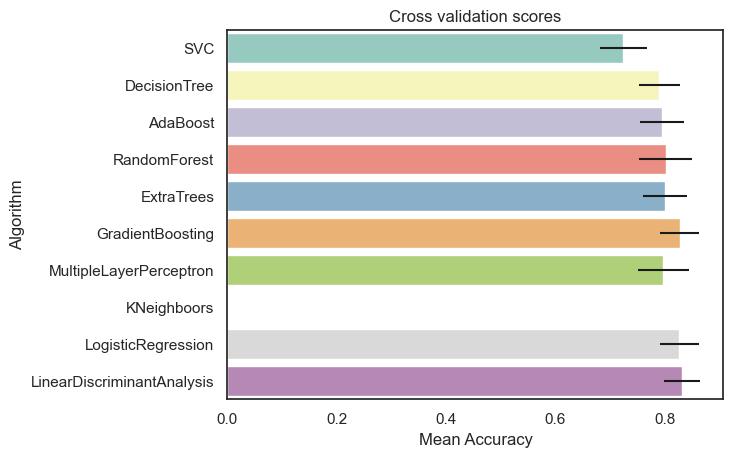

In [218]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state)) 
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs = 4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm' : ['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees',
                                                                                           'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighboors',
                                                                                           'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot(x='CrossValMeans', y='Algorithm', data = cv_res, palette = 'Set3', orient = 'h', **{'xerr': cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

### 6.1.2 Hyperparameter tunning for best models

In [219]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion' : ['gini', 'entropy'],
                  'base_estimator__splitter' : ['best', 'random'],
                  'algorithm' : ['SAMME', 'SAMME.R'],
                  'n_estimators': [1, 2],
                  'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid= ada_param_grid, cv = kfold, scoring='accuracy', n_jobs = 4, verbose = 1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/Users/leewonseok/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/leewonseok/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/leewonseok/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/leewonseok/anaconda3/lib/python3.10/site-packages/skle

In [220]:
gsadaDTC.best_score_

0.8127681307456587

In [228]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth' : [None],
                 'max_features' : [1, 3, 10],
                 'min_samples_split' : [2, 3, 10],
                 'min_samples_leaf' : [1, 3, 10],
                 'bootstrap' : [False],
                 'n_estimators' : [100, 300],
                 'criterion' : ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8173008171603678

In [223]:
RFC = RandomForestClassifier()

rf_param_grid = {'max_depth' : [None],
                 'max_features' : [1, 3, 10],
                 'min_samples_split' : [2, 3, 10],
                 'min_samples_leaf' : [1, 3, 10],
                 'bootstrap' : [False],
                 'n_estimators' : [100, 300],
                 'criterion' : ['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8161899897854955

In [225]:
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss' : ['log_loss', 'exponential'],
                 'n_estimators' : [100, 200, 300],
                 'learning_rate' : [0.1, 0.05, 0.01],
                 'max_depth' : [4, 8],
                 'min_samples_leaf' : [100, 150],
                 'max_features' : [0.3, 0.1]
                 }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


0.8331460674157304

In [226]:
SVMC = SVC(probability=True)

svc_param_grid = {'kernel' : ['rbf'],
                 'gamma' : [0.001, 0.01, 0.1, 1],
                 'C' : [1, 10, 50, 100, 200, 300, 1000]
                 }

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.831996935648621

### 6.1.3 Plot learning curves

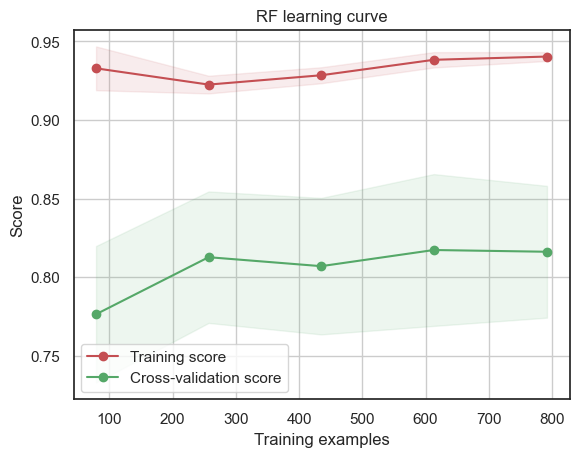

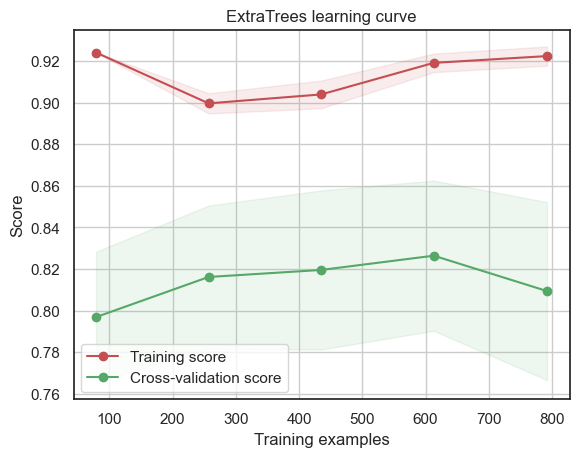

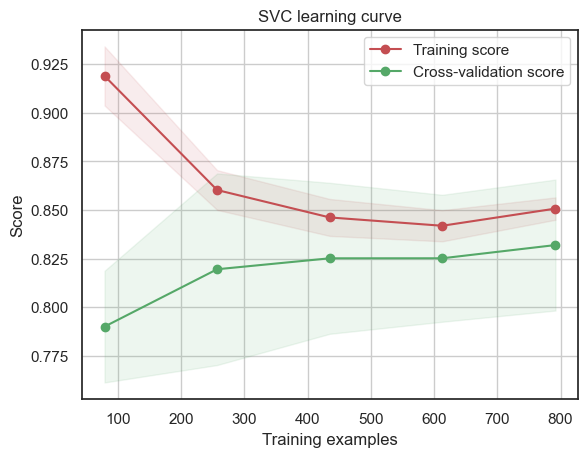

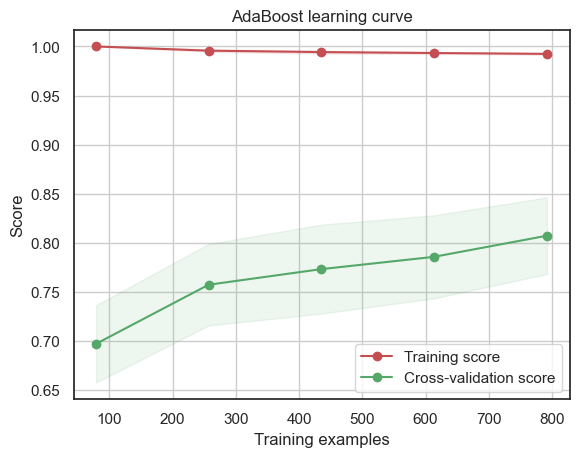

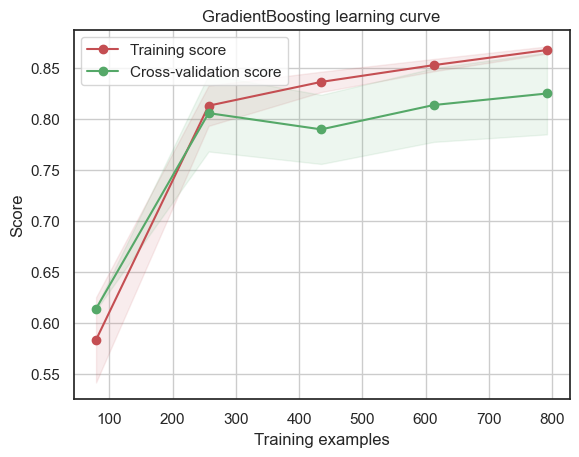

In [227]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')

    plt.legend(loc = 'best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, "RF learning curve", X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curve", X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curve", X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curve", X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curve", X_train, Y_train, cv = kfold)

### 6.1.4 Feature importance of tree based classifiers

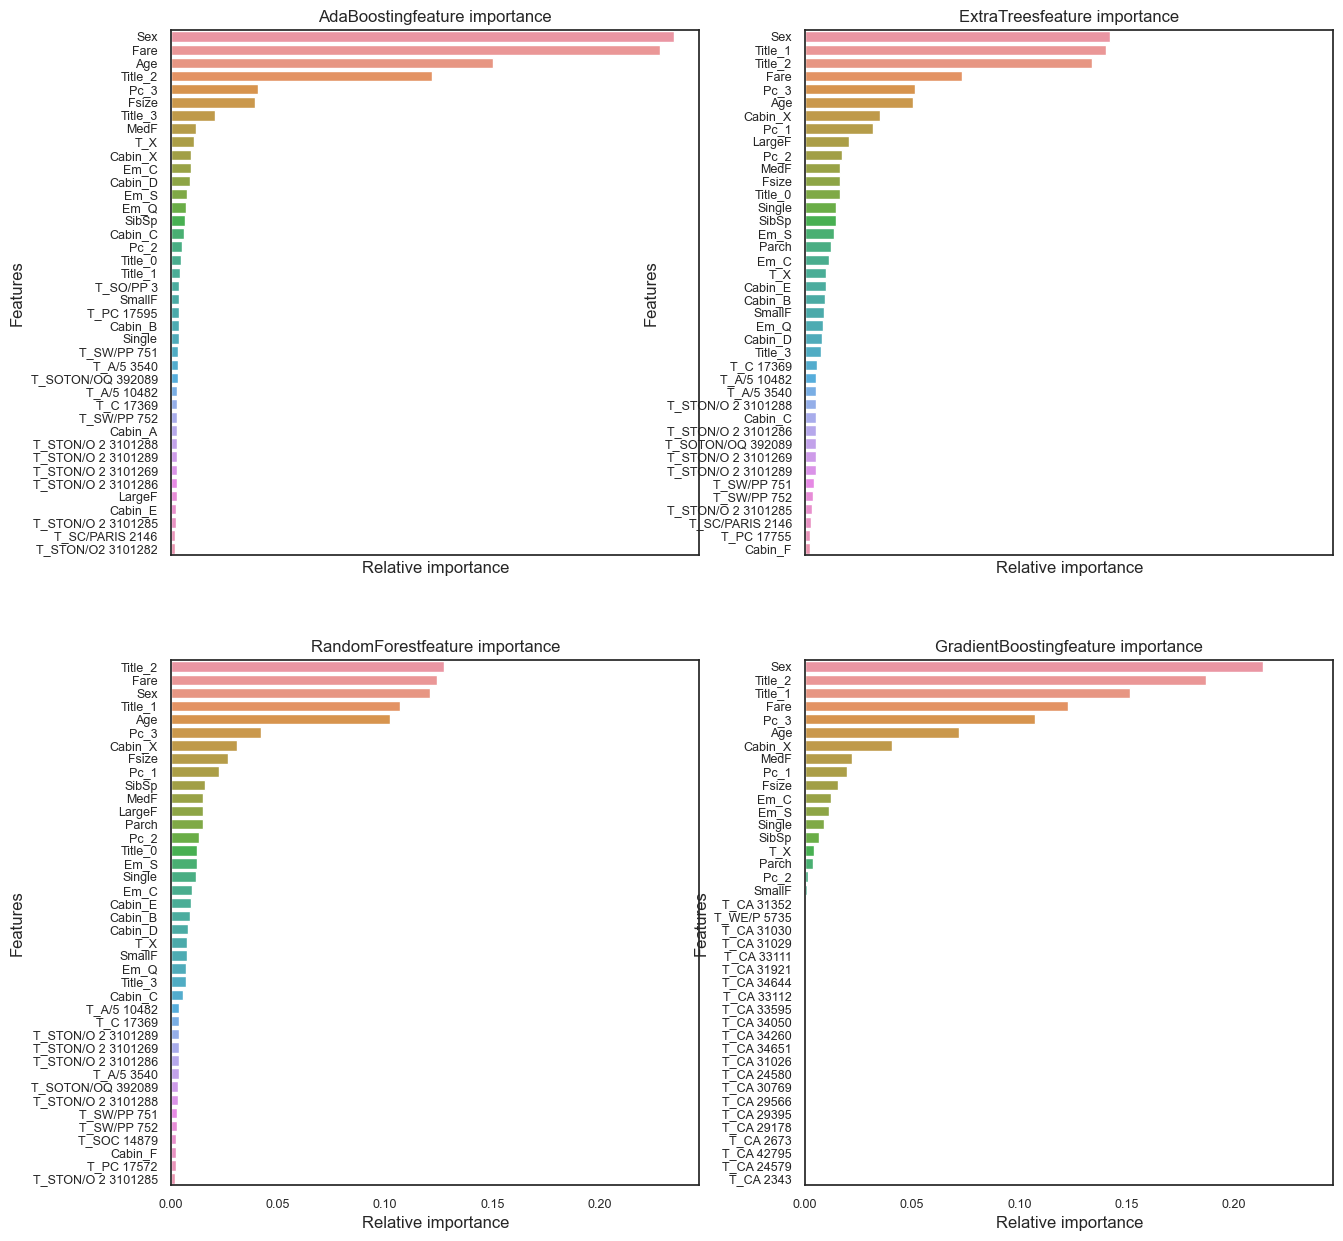

In [230]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, sharex = 'all', figsize = (15, 15))

names_classifiers = [('AdaBoosting', ada_best) , ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting' , GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y = X_train.columns[indices][:40], x = classifier.feature_importances_[indices][:40], orient = 'h', ax=axes[row][col])
        g.set_xlabel('Relative importance', fontsize = 12)
        g.set_ylabel('Features' ,fontsize = 12)
        g.tick_params(labelsize = 9)
        g.set_title(name + 'feature importance')
        nclassifier +=1

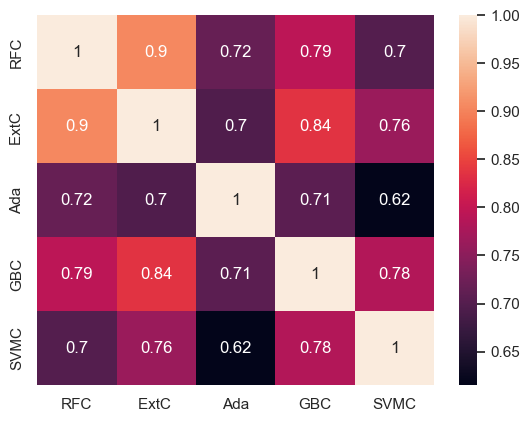

In [231]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name = 'RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name = 'ExtC ')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name = 'SVMC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name = 'Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name = 'GBC')

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis = 1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

## 6.2 Ensemble modeling

### 6.2.1 Combingin models

In [232]:
votingC = VotingClassifier(estimators=[('AdaBoosting', ada_best) , ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting' , GBC_best)],
                           voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

## 6.3 Prediction

### 6.3.1 Predict and Submit results

In [233]:
test_Survived = pd.Series(votingC.predict(test), name = 'Survived')

results  = pd.concat([IDtest, test_Survived], axis = 1)

results.to_csv('ensemble_python_voting.csv', index = False)